<a href="https://colab.research.google.com/github/ayusufsirin/stereo_vision_starter/blob/main/kitti_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Requirements

Set the Colab runtime type to "T4 GPU"

In [1]:
# !nvcc --version


In [2]:
# !nvidia-smi


In [3]:
# !pip install cupy-cuda12x


In [4]:
# !pip install GitPython open3d


## Running the Algthm

In [5]:
import os
from glob import glob
import cv2
import open3d as o3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
# Clone the git repo
from git import Repo
import os

repo_url = 'https://github.com/ayusufsirin/stereo_vision_starter'
local_dir = 'stereo_vision_starter'

# Check if the directory exists and is a Git repository
if os.path.isdir(local_dir) and os.path.isdir(os.path.join(local_dir, '.git')):
    try:
        repo = Repo(local_dir)
        # Ensure the local repository is linked to the specified URL
        if repo.remotes.origin.url == repo_url:
            print("Repository already exists, pulling latest changes...")
            repo.remotes.origin.pull()
        else:
            print("Directory exists but is not linked to the specified repository URL.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    try:
        print("Cloning repository...")
        Repo.clone_from(repo_url, local_dir)
        print("Repository cloned successfully.")
    except Exception as e:
        print(f"An error occurred while cloning the repository: {e}")


Repository already exists, pulling latest changes...
An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git pull -v -- origin
  stderr: 'fatal: detected dubious ownership in repository at '/media/joseph/Development/SFITC/stereo_vision_starter/stereo_vision_starter''


In [7]:
DATA_PATH = r'stereo_vision_starter/dataset/data_scene_flow/training/'
RAW_DATA_PATH = r'stereo_vision_starter/dataset/2011_09_26/2011_09_26_drive_0057_sync'

left_image_paths = sorted(
    glob(os.path.join(RAW_DATA_PATH, 'image_02/data/0000000125.png')))
right_image_paths = sorted(
    glob(os.path.join(RAW_DATA_PATH, 'image_03/data/0000000125.png')))

# get LiDAR data
gt_paths = sorted(glob(os.path.join(DATA_PATH, 'disp_noc_0/000112_10.png')))

lidar_paths = sorted(
    glob(os.path.join(RAW_DATA_PATH, 'velodyne_points/data/0000000125.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(lidar_paths)}")
print(f"Number of GT point clouds: {len(gt_paths)}")


Number of left images: 1
Number of right images: 1
Number of LiDAR point clouds: 1
Number of GT point clouds: 1


In [8]:
calib_paths = sorted(glob(
    'stereo_vision_starter/dataset/data_scene_flow_calib/training/calib_cam_to_cam/000112.txt'))

with open(calib_paths[0], 'r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x)
                  for x in calib[25].strip().split(' ')[1:]]).reshape((3, 4))
P_right = np.array([float(x)
                   for x in calib[33].strip().split(' ')[1:]]).reshape((3, 4))

# get rectified rotation matrices
R_left_rect = np.array(
    [float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array(
    [float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0, 0, 0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0, 0, 0, 1], axis=1)


In [9]:
def decompose_projection_matrix(P):
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T


In [10]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)


In [11]:
print(T_left)
print(R_left)


[[-5.98492648e-02]
 [ 3.57927150e-04]
 [-2.74588400e-03]
 [ 1.00000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [12]:
calib_paths = sorted(glob(
    'stereo_vision_starter/dataset/data_scene_flow_calib/training/calib_velo_to_cam/*.txt'))

with open(calib_paths[0], 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x)
                      for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x)
                      for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

T_cam_velo


array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [13]:
index = 0

left_image = cv2.cvtColor(cv2.imread(
    left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(
    right_image_paths[index]), cv2.COLOR_BGR2RGB)


In [14]:
print(f"The shape of an image is: {left_image.shape}")


The shape of an image is: (375, 1242, 3)


Text(0.5, 1.0, 'Right Image')

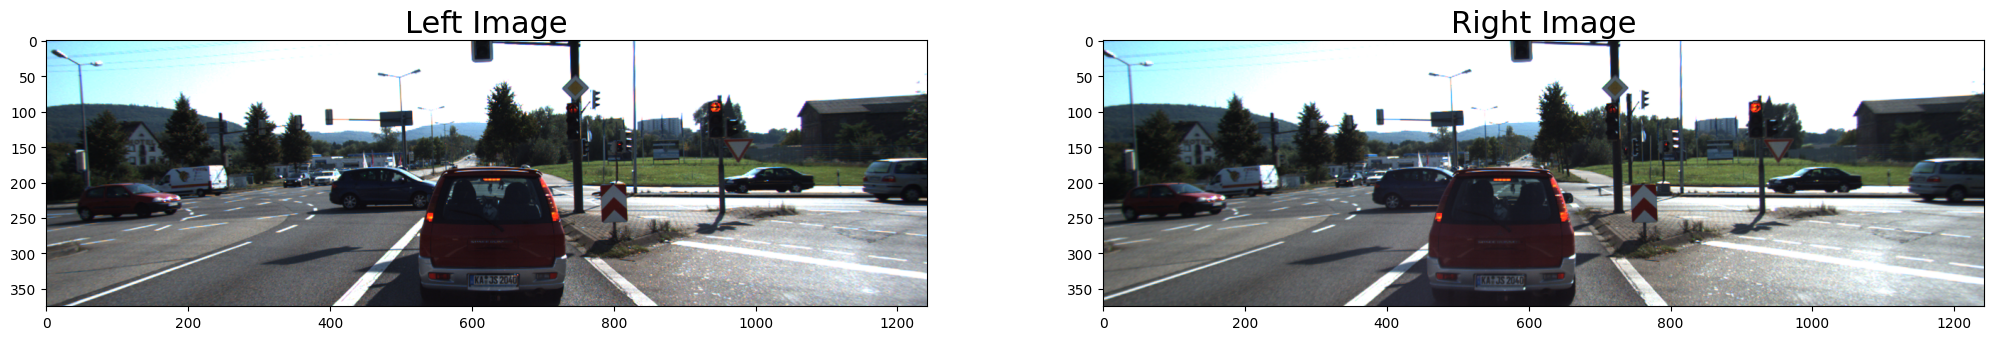

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22)


In [16]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16,
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs:
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images

        NOTE: image_left must be the left image (same for the right) or
              unexpected results will occur due to
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size,
                                     P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

    # compute disparity
    disparity = sgbm_obj.compute(
        left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
        plt.figure(figsize=(40, 20))
        plt.imshow(disparity, cmap='cividis')
        plt.title('Disparity Map', size=25)
        plt.show()

    return disparity


def calc_depth_map(disp_left, K_left, T_left, T_right):
    ''' Computes Depth map from Intrinsic Camera Matrix and Translations vectors.
        For KITTI, the depth is in meters.
        '''
    # Get the focal length from the K matrix
    f = K_left[0, 0]

    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(T_left[0] - T_right[0])[0]

    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 1e-5

    # Calculate the depths
    depth_map = f*b / disp_left

    return depth_map


In [17]:
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)


In [18]:
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

disparity = interactive(compute_sgbm_disparity,
                        left_image=fixed(left_image_gray),
                        right_image=fixed(right_image_gray),
                        num_disparities=(0, 512, 16),
                        block_size=(1, 19, 2),
                        window_size=(1, 13, 2),
                        display=fixed(True))
display(disparity)


interactive(children=(IntSlider(value=80, description='num_disparities', max=512, step=16), IntSlider(value=11…

In [19]:
num_disparities = disparity.kwargs['num_disparities']
block_size = disparity.kwargs['block_size']
window_size = disparity.kwargs['window_size']


In [20]:
disparity = compute_sgbm_disparity(left_image_gray,
                                   right_image_gray,
                                   num_disparities,
                                   block_size,
                                   window_size,
                                   display=False)


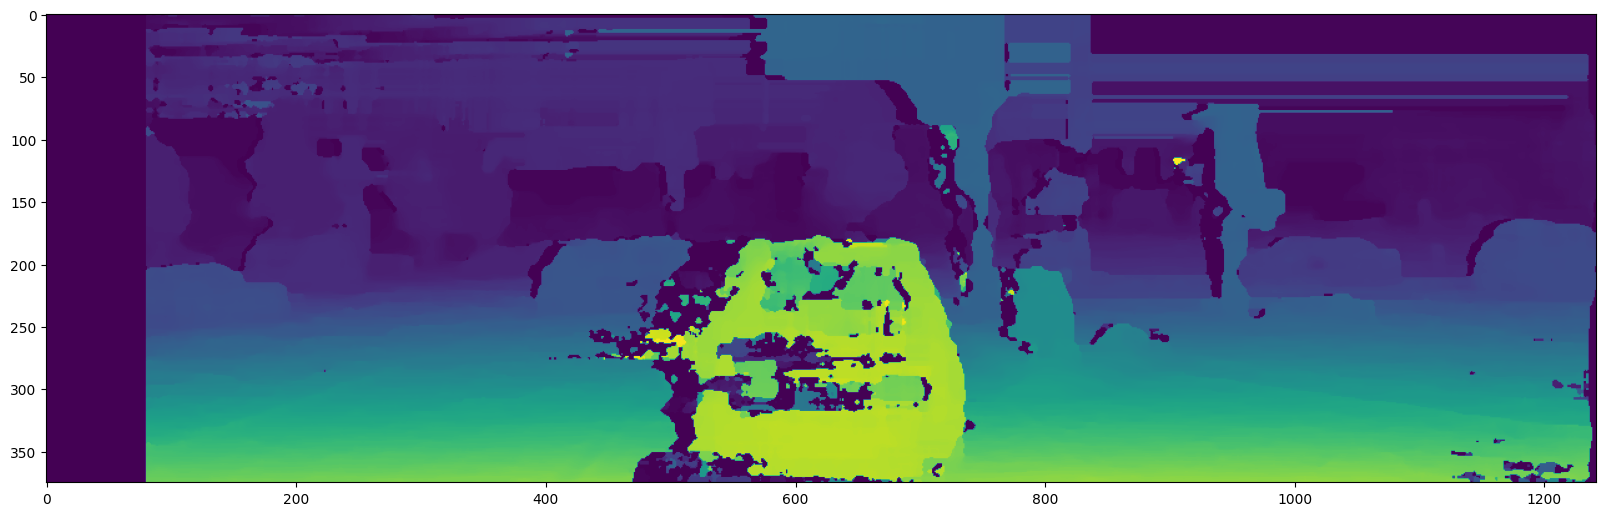

In [21]:
plt.imshow(disparity)


nan

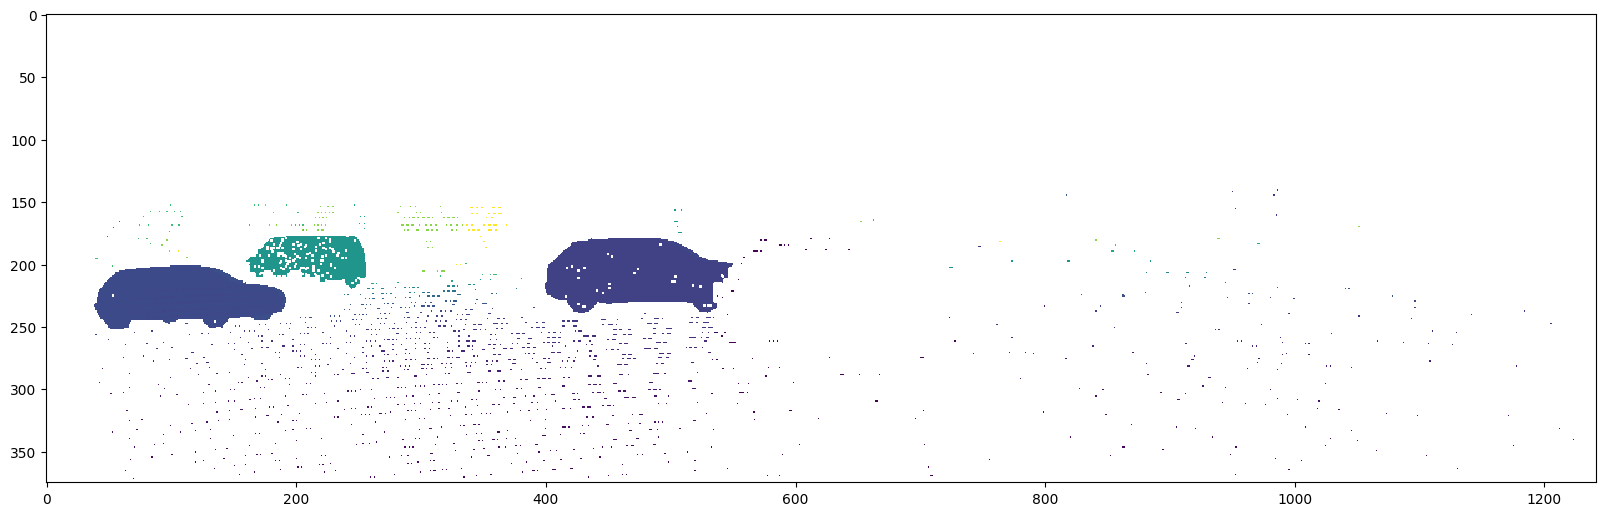

In [22]:
gt = gt_paths[index]

gt_disp = cv2.imread(gt, cv2.IMREAD_GRAYSCALE)
# print(gt, type(gt_depth_map))

gt_disp = gt_disp.astype(np.float32)
# gt_disp[gt_disp == 0] = 1e-05

gt_depth_map = calc_depth_map(gt_disp, K_left, T_left, T_right)
gt_depth_map[gt_depth_map > 38000000.0] = np.NAN
# gt_depth_map[gt_depth_map == 0] = np.NAN
# gt_depth_map[gt_depth_map == np.Infinity] = np.NAN

plt.imshow(gt_depth_map)
gt_depth_map[50, 600]


In [23]:
def get_velo2cam(lidar_bin):
    ''' Converts the LiDAR point cloud to camera (u, v, z) image coordinates,
        where z is in meters
        '''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1, 4))

    # convert to homogeneous coordinate system
    velo_points = scan_data[:, 0:3]  # (x, y, z) --> (front, left, up)
    # homogeneous LiDAR points
    velo_points = np.insert(velo_points, 3, 1, axis=1).T

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(
        velo_points[3, :] < 0), axis=1)

    # possibly use RANSAC to remove the ground plane for better viewing?

    # convert to camera coordinates
    velo_camera = P_left @ R_left_rect @ T_cam_velo @ velo_points

    # delete negative camera points ??
    velo_camera = np.delete(velo_camera, np.where(
        velo_camera[2, :] < 0)[0], axis=1)

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    return velo_camera


def project_velo2cam(lidar_bin, image):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get camera (u, v, z) coordinates
    velo_camera = get_velo2cam(lidar_bin)

    (u, v, z) = velo_camera

    # remove outliers (points outside of the image frame)
    img_h, img_w, _ = image.shape
    u_out = np.logical_or(u < 0, u > img_w)
    v_out = np.logical_or(v < 0, v > img_h)
    outlier = np.logical_or(u_out, v_out)
    velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera


In [24]:
lidar_bin = lidar_paths[index]
(u, v, z) = project_velo2cam(lidar_bin, left_image)


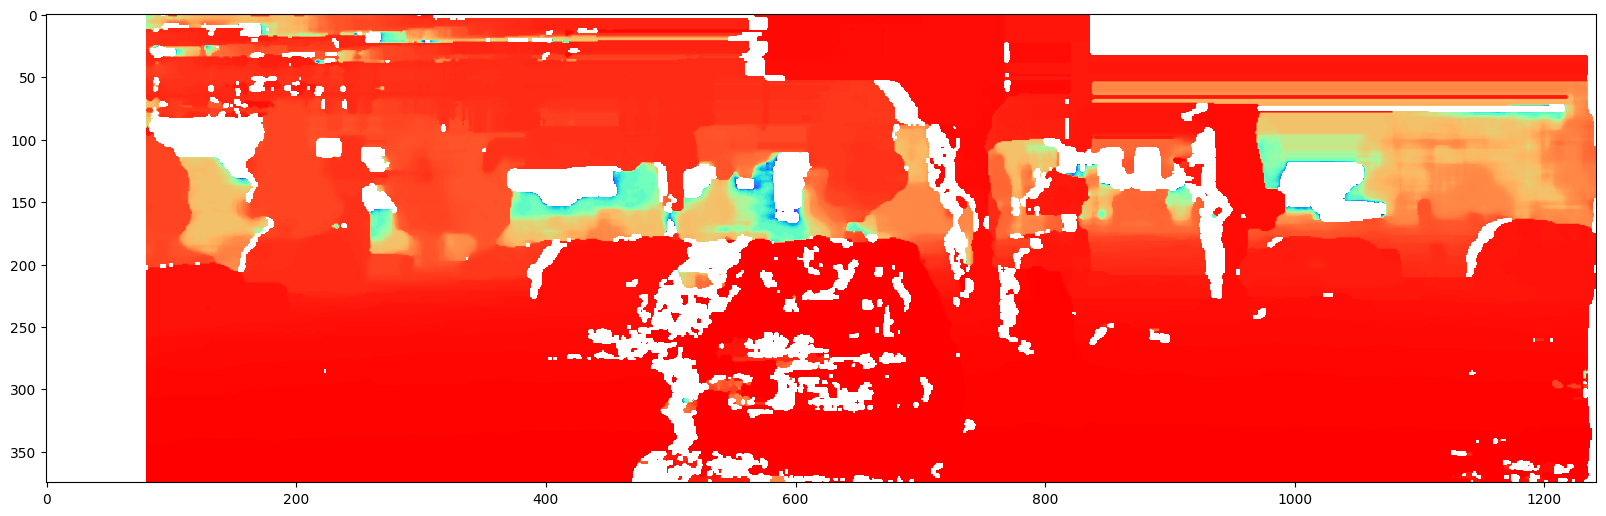

In [25]:
stereo_depth_map = calc_depth_map(disparity, K_left, T_left, T_right)
stereo_depth_map[stereo_depth_map > 38000000.0] = np.NAN

plt.imshow(stereo_depth_map, cmap='rainbow_r')  # or 'cividis_r' or 'cividis'


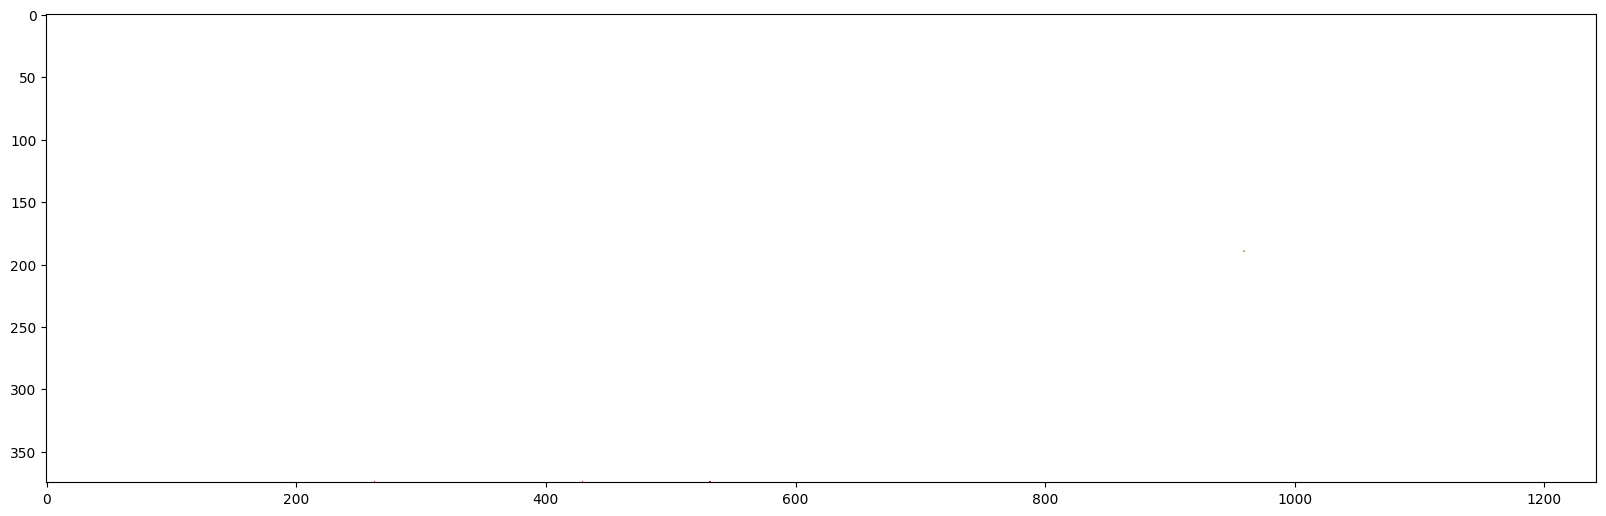

In [26]:
def uvz_to_depth_map(uvz, image_shape):
    depth_map = np.zeros(image_shape, dtype=np.float32)

    u, v, z = uvz
    u, v = u.astype(np.int32), v.astype(np.int32)

    valid_indices = (u >= 0) & (u < image_shape[1]) & (
        v >= 0) & (v < image_shape[0])
    u, v, z = u[valid_indices], v[valid_indices], z[valid_indices]

    depth_map[v, u] = z

    return depth_map


lidar_depth_map = uvz_to_depth_map((u, v, z), stereo_depth_map.shape)

# TODO: Why not working?
lidar_depth_map[lidar_depth_map == 0] = np.NAN

plt.imshow(lidar_depth_map, cmap='rainbow_r')


## Overlapping

In [27]:
lidar_depth_map.shape


(375, 1242)

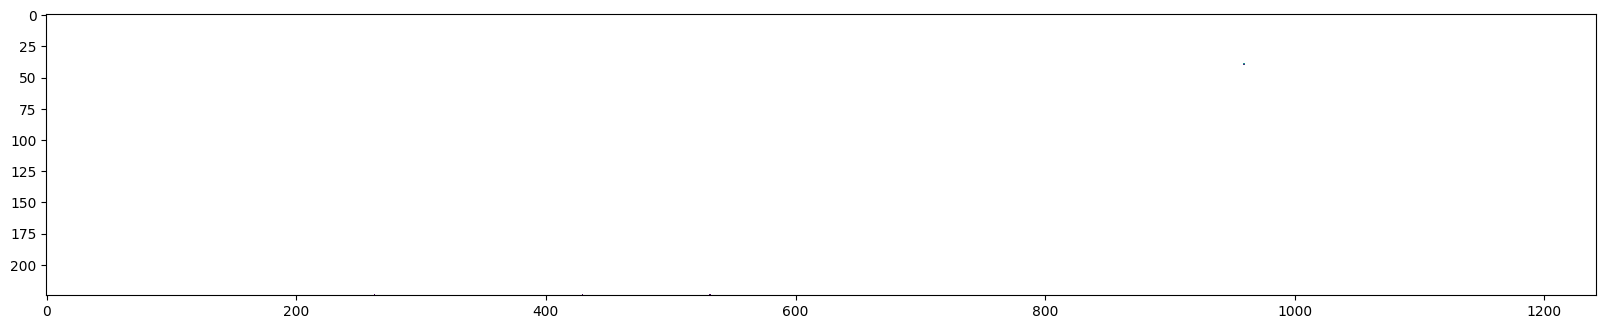

In [28]:
# TODO: Make this dynamic

plt.imshow(lidar_depth_map[150:, :])


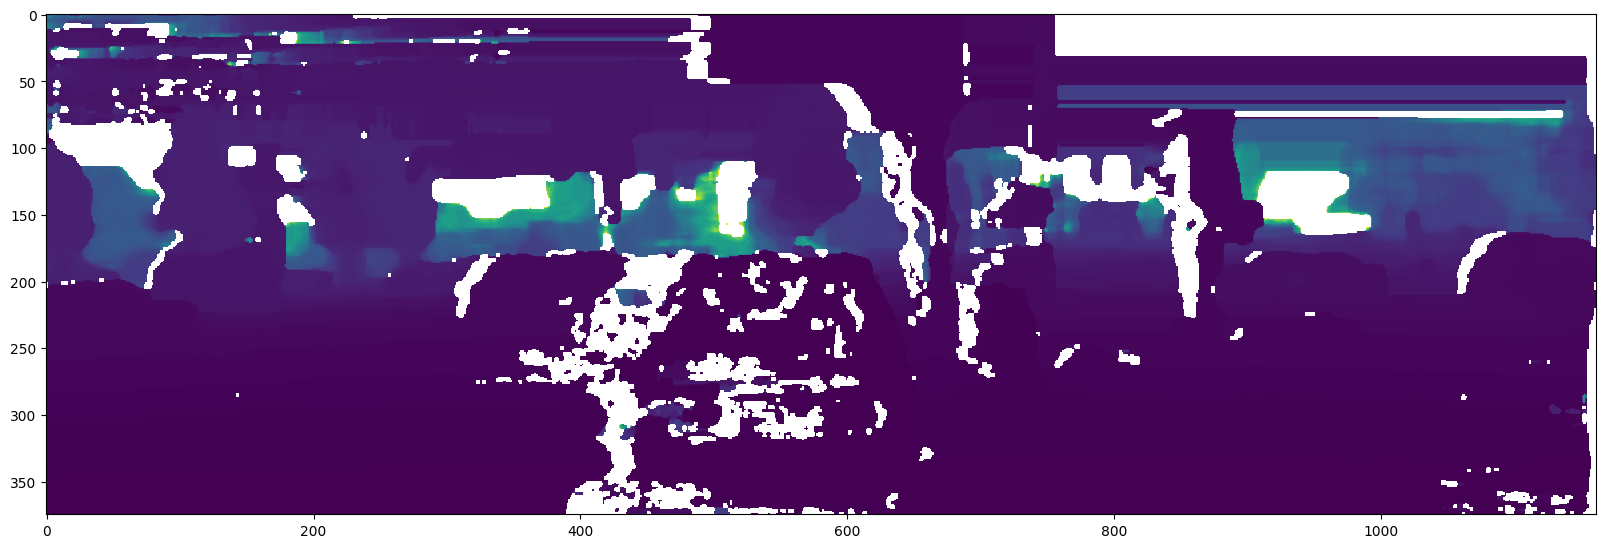

In [29]:
plt.imshow(stereo_depth_map[:, 80:])


## Point Cloud

In [30]:
def depth_map_to_point_cloud(depth_map, flip=True):
    # Convert the depth map to Open3D depth image
    depth_image_o3d = o3d.geometry.Image(depth_map.astype(np.float32))

    # Create an Intrinsics object using camera parameters
    height, width = depth_map.shape
    fx, fy = K_left[0, 0], K_left[1, 1]
    cx, cy = K_left[0, 2], K_left[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, height, fx, fy, cx, cy)

    # Create a point cloud from the depth image
    point_cloud = o3d.geometry.PointCloud.create_from_depth_image(
        depth_image_o3d,
        intrinsic,
        # depth_scale=1,
        # depth_trunc=0.00070
    )

    if flip:
        point_cloud.transform([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1]
        ])

    return point_cloud


def rgbd_to_point_cloud(color, depth_map, flip=True):
    # Convert the depth map to Open3D depth image
    depth_image_o3d = o3d.geometry.Image(depth_map.astype(np.float32))

    # Convert the depth map to Open3D depth image
    color_image_o3d = o3d.geometry.Image(color)

    # Create RGBD image
    rgbd_image_o3d = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_image_o3d,
        depth_image_o3d,
        depth_scale=1,
        depth_trunc=70
    )

    # Create an Intrinsics object using camera parameters
    height, width = depth_map.shape
    fx, fy = K_left[0, 0], K_left[1, 1]
    cx, cy = K_left[0, 2], K_left[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, height, fx, fy, cx, cy)

    # Create a point cloud from the depth image
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image_o3d, intrinsic)

    if flip:
        point_cloud.transform([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1]
        ])

    return point_cloud

# # Visualize the point cloud
# o3d.visualization.draw_geometries([
#     # depth_map_to_point_cloud(stereo_depth_map),
#     depth_map_to_point_cloud(lidar_depth_map),
#     rgbd_to_point_cloud(left_image, stereo_depth_map),
# ])


## PG Implementation

245604
17810
0


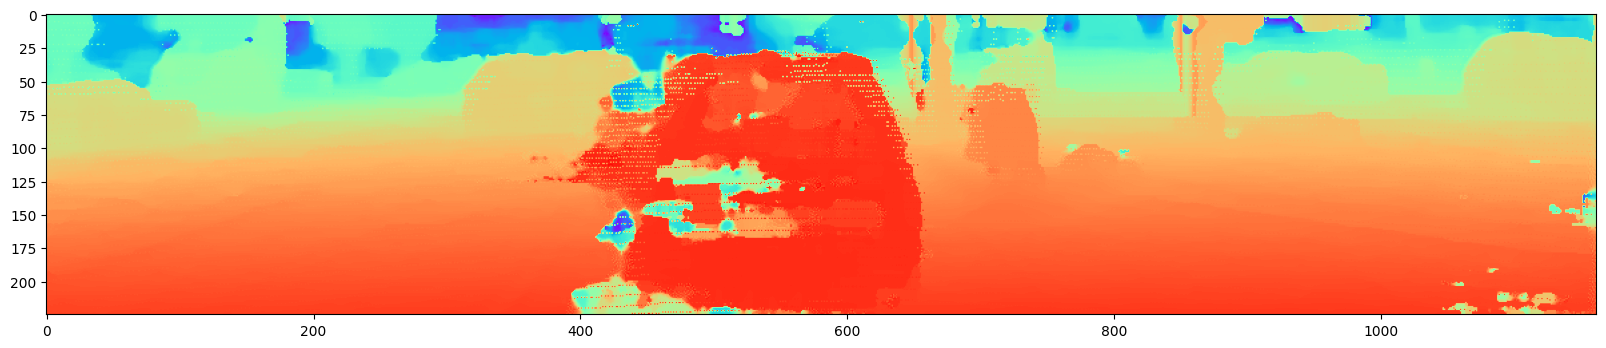

In [31]:
import cupy as cp

# vlp_depth = cp.array(lidar_depth_map)
# zed_depth = cp.array(stereo_depth_map)
# rgb = cp.array(left_image)
gt_depth = cp.array(gt_depth_map[150:, 80:])
vlp_depth = cp.array(lidar_depth_map[150:, 80:])
zed_depth = cp.array(stereo_depth_map[150:, 80:])
rgb = cp.array(left_image[150:, 80:])


def fillB_withA(A, B):
    # Combine A and B, prioritizing non-NaN values in A
    combined = cp.where(cp.isnan(A), B, A)

    # Calculate the column-wise means of the combined matrix, ignoring NaNs
    col_means = cp.nanmean(combined, axis=0)

    # Replace NaN values in the combined matrix with the column-wise means
    combined = cp.where(cp.isnan(combined), col_means, combined)

    return combined


print(cp.count_nonzero(cp.isnan(vlp_depth)))
print(cp.count_nonzero(cp.isnan(zed_depth)))

mask = cp.isnan(zed_depth)

zed_depth = cp.array(cv2.inpaint(
    zed_depth.get(), mask.get().astype(np.uint8), 3, cv2.INPAINT_TELEA))

# zed_depth[cp.isnan(zed_depth)] = vlp_depth.mean()
# zed_depth[cp.isnan(zed_depth)] = vlp_depth.max()
# zed_depth[cp.isnan(zed_depth)] = vlp_depth.min()
# zed_depth[zed_depth > 2000] = vlp_mean

zed_depth = fillB_withA(vlp_depth, zed_depth)

print(cp.count_nonzero(cp.isnan(zed_depth)))

plt.imshow(np.log(zed_depth.get()), cmap='rainbow_r')


/tmp/ipykernel_21205/162492979.py:77: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(pg_depth.get() - zed_depth.get()), cmap='rainbow_r')
/tmp/ipykernel_21205/162492979.py:77: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(pg_depth.get() - zed_depth.get()), cmap='rainbow_r')


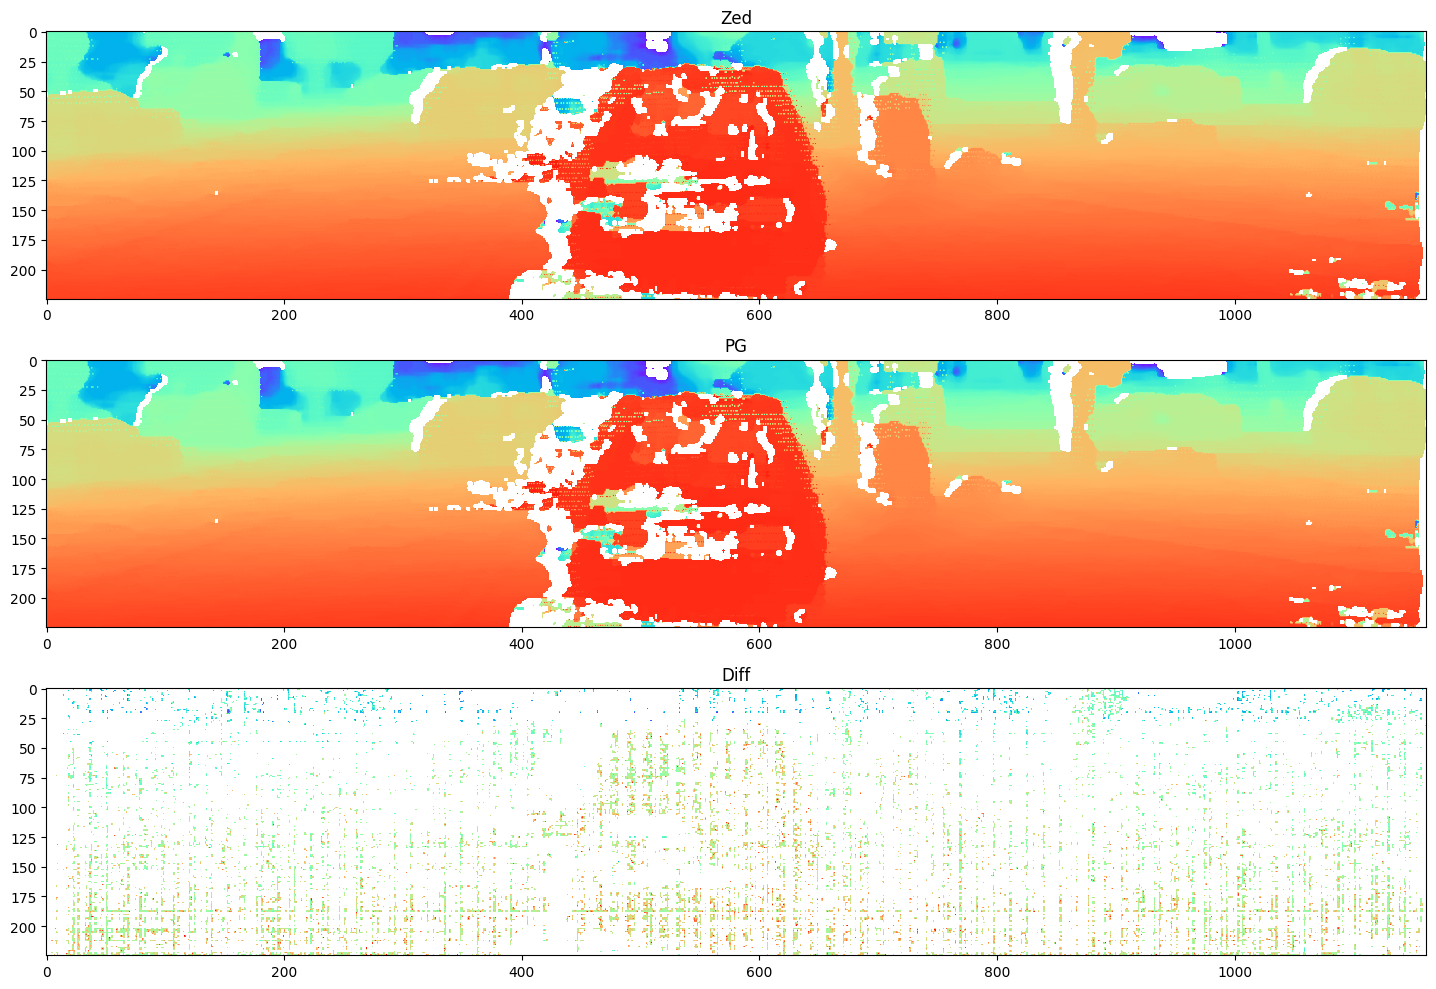

In [32]:
def comp_filt(img):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape

    fshift_filtered = fshift
    fshift_filtered[520:642, 0:75] = 0
    fshift_filtered[520:642, 150::] = 0


    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered


def pg(zed_depth, vlp_depth, ncutoff, threshold=100):
    mask = vlp_depth > 0
    filtered = zed_depth

    while threshold > 0:
        filtered[mask] = vlp_depth[mask]
        filtered = comp_filt(filtered)

        threshold -= 1
        # ncutoff = ncutoff / 10

    return filtered


pg_depth = pg(
    # cp.array(zed_depth.copy()),
    # cp.array(vlp_depth.copy()),
    cp.log(cp.array(zed_depth.copy())),
    cp.log(cp.array(vlp_depth.copy())),
    ncutoff=0.8,
    threshold=10
)

# Null masking
pg_depth = cp.exp(pg_depth)
pg_depth[mask] = cp.NAN
masked_zed_depth = zed_depth.copy()
masked_zed_depth[mask] = cp.NAN

# # Edge sharpenning
# from cupyx.scipy.ndimage import convolve
# sharpening_kernel = cp.array([
#     [0, -1, 0],
#     [-1, 5, -1],
#     [0, -1, 0]
# ])
# pg_depth = convolve(pg_depth, sharpening_kernel)

# Plotting
vmin = np.min([np.ma.masked_invalid(np.log(pg_depth.get())).min(), np.ma.masked_invalid(np.log(zed_depth.get())).min()])
vmax = np.max([np.ma.masked_invalid(np.log(pg_depth.get())).max(), np.ma.masked_invalid(np.log(zed_depth.get())).max()])

plt.subplot(3, 1, 1)
plt.imshow(np.log(masked_zed_depth.get()), cmap='rainbow_r', vmin=vmin, vmax=vmax)
plt.title('Zed')

plt.subplot(3, 1, 2)
plt.imshow(np.log(pg_depth.get()), cmap='rainbow_r', vmin=vmin, vmax=vmax)
plt.title('PG')

plt.subplot(3, 1, 3)
plt.imshow(np.log(pg_depth.get() - zed_depth.get()), cmap='rainbow_r')
plt.title('Diff')

plt.tight_layout()
plt.show()


In [33]:
# Visualize the point cloud
# o3d.visualization.draw_plotly([
o3d.visualization.draw_geometries([
    # depth_map_to_point_cloud(zed_depth.get()),
    # rgbd_to_point_cloud(rgb.get(), masked_zed_depth.get()),
    # depth_map_to_point_cloud(vlp_depth.get()),
    # depth_map_to_point_cloud(gt_depth.get()),
    rgbd_to_point_cloud(rgb.get(), pg_depth.get()),
    # depth_map_to_point_cloud(pg_depth.get()),
])


## Benchmark


### Custom MAE

In [34]:
def calculate_custom_mae(predicted, ground_truth, max_error=0.1):
    """
    Calculate a custom Mean Absolute Error (MAE) between predicted and ground truth images.
    NaN values in the ground truth are ignored. NaN values in the predicted image, where
    the ground truth is not NaN, are penalized.

    Parameters:
    predicted (numpy.ndarray): Predicted depth image.
    ground_truth (numpy.ndarray): Ground truth depth image.

    Returns:
    float: The custom MAE value.
    """
    error = (ground_truth - predicted)  / ground_truth
    
    error = np.ma.masked_less(error, -max_error)
    error = np.ma.masked_greater(error, max_error)
    error = np.ma.masked_invalid(error)
    
    mae = np.nanmean(np.abs(error))

    return mae * 100


print(calculate_custom_mae(gt_depth.get(), gt_depth.get()))
print(calculate_custom_mae(pg_depth.get(), gt_depth.get()))
print(calculate_custom_mae(masked_zed_depth.get(), gt_depth.get()))
print(calculate_custom_mae(vlp_depth.get(), gt_depth.get()))


0.0
2.0433684810996056
2.0445559173822403
2.921443246304989


### RMSE

In [35]:
def calculate_rmse(predicted, ground_truth, max_error=0.1):
    """
    Calculate the Root Mean Square Error (RMSE) between predicted and ground truth images,
    taking into account NaN values.

    Parameters:
    predicted (numpy.ndarray): Predicted depth image.
    ground_truth (numpy.ndarray): Ground truth depth image.

    Returns:
    float: The RMSE value.
    """
    error = (ground_truth - predicted)  / ground_truth
    
    error = np.ma.masked_less(error, -max_error)
    error = np.ma.masked_greater(error, max_error)
    error = np.ma.masked_invalid(error)

    rmse = np.sqrt(np.mean(np.square(error)))
    
    return rmse * 100


print(calculate_rmse(gt_depth.get(), gt_depth.get()))
print(calculate_rmse(pg_depth.get(), gt_depth.get()))
print(calculate_rmse(masked_zed_depth.get(), gt_depth.get()))
print(calculate_rmse(vlp_depth.get(), gt_depth.get()))


0.0
2.956817386202929
2.959193919661368
3.639739511527093


### edge_preservation_quality (USELESS)

In [36]:
# import numpy as np
# from skimage.filters import sobel
# from skimage.measure import label
# from scipy.ndimage import binary_dilation
# from skimage.metrics import structural_similarity as ssim

# def preprocess_image(image):
#     """
#     Replace NaN values with 0, assuming NaNs indicate missing data.
#     """
#     return np.nan_to_num(image, nan=0)

# def dilate_edges(edges, iterations=5):
#     """
#     Dilate the edges to account for sparsity in the ground truth.

#     Parameters:
#     edges (numpy.ndarray): Edge map.
#     iterations (int): Number of dilation iterations.

#     Returns:
#     numpy.ndarray: Dilated edge map.
#     """
#     return binary_dilation(edges, iterations=iterations)

# def calculate_custom_edge_metric(predicted_edges, ground_truth_edges):
#     """
#     Calculate a custom edge metric considering the dilated ground truth edges.

#     Parameters:
#     predicted_edges (numpy.ndarray): Edge map from the predicted image.
#     ground_truth_edges (numpy.ndarray): Dilated edge map from the ground truth image.

#     Returns:
#     float: Custom metric based on the comparison.
#     """
#     # Calculate discrepancies
#     missing_edges = np.logical_and(~predicted_edges, ground_truth_edges)
#     false_edges = np.logical_and(predicted_edges, ~ground_truth_edges)

#     # Penalization factors (tunable)
#     missing_edge_penalty = 1.0
#     false_edge_penalty = 1.0

#     # Calculate penalties
#     missing_edge_score = np.sum(missing_edges) * missing_edge_penalty
#     false_edge_score = np.sum(false_edges) * false_edge_penalty

#     # Normalize by the number of ground truth edges
#     total_ground_truth_edges = np.sum(ground_truth_edges)

#     if total_ground_truth_edges > 0:
#         score = (missing_edge_score + false_edge_score) / total_ground_truth_edges
#     else:
#         score = 0  # Handle case with no ground truth edges

#     return score

# def evaluate_edge_preservation(predicted, ground_truth):
#     """
#     Evaluate edge preservation quality with penalization for sparsity.

#     Parameters:
#     predicted (numpy.ndarray): Predicted depth image.
#     ground_truth (numpy.ndarray): Ground truth depth image.

#     Returns:
#     float: Custom edge preservation score.
#     """
#     # Preprocess images
#     predicted_preprocessed = preprocess_image(predicted)
#     ground_truth_preprocessed = preprocess_image(ground_truth)

#     # Detect edges
#     predicted_edges = sobel(predicted_preprocessed) > 0.01  # Edge threshold
#     ground_truth_edges = sobel(ground_truth_preprocessed) > 0.01

#     # Handle sparsity by dilating ground truth edges
#     dilated_ground_truth_edges = dilate_edges(ground_truth_edges)

#     # Calculate custom edge metric
#     score = calculate_custom_edge_metric(predicted_edges, dilated_ground_truth_edges)

#     return score


# print(evaluate_edge_preservation(gt_depth.get(), gt_depth.get()))
# print(evaluate_edge_preservation(pg_depth.get(), gt_depth.get()))
# print(evaluate_edge_preservation(masked_zed_depth.get(), gt_depth.get()))
# print(evaluate_edge_preservation(vlp_depth.get(), gt_depth.get()))


### depth_consistency

In [37]:
# import numpy as np

# def calculate_depth_consistency(predicted, ground_truth, min_valid_points=10):
#     """
#     Calculate depth consistency in regions with sufficient ground truth data.

#     Parameters:
#     predicted (numpy.ndarray): Dense predicted depth image.
#     ground_truth (numpy.ndarray): Sparse ground truth depth image.
#     min_valid_points (int): Minimum number of valid ground truth points to consider a region.

#     Returns:
#     dict: A dictionary containing variance metrics for both predicted and ground truth, and a consistency score.
#     """
#     if predicted.shape != ground_truth.shape:
#         raise ValueError("Predicted and ground truth images must have the same shape.")

#     # Mask for valid ground truth points
#     valid_gt_mask = ~np.isnan(ground_truth)

#     # Mask for pixels where predicted is NaN but ground truth is not
#     valid_pred_mask = ~np.isnan(predicted)

#     # Identify regions with sufficient ground truth data
#     # Here, we simplify by considering the entire image as a single region if it has enough valid points
#     if np.sum(valid_gt_mask) < min_valid_points:
#         return {"error": "Not enough valid ground truth points for comparison."}

#     # Calculate variance in these regions for both predicted and ground truth
#     gt_variance = np.var(ground_truth[valid_gt_mask])
#     pred_variance = np.var(predicted[valid_pred_mask])

#     # Compare variances to assess consistency. A lower difference indicates better consistency.
#     variance_difference = np.abs(gt_variance - pred_variance)

#     # Return the variances and the difference as a measure of consistency
#     return {
#         "ground_truth_variance": gt_variance,
#         "predicted_variance": pred_variance,
#         "consistency_score": 1 / (1 + variance_difference)  # Higher score indicates better consistency
#     }


# print(calculate_depth_consistency(gt_depth.get(), gt_depth.get()))
# print(calculate_depth_consistency(pg_depth.get(), gt_depth.get()))
# print(calculate_depth_consistency(masked_zed_depth.get(), gt_depth.get()))
# print(calculate_depth_consistency(vlp_depth.get(), gt_depth.get()))


## Benchmark PoC

In [38]:
A = np.array([
    [2, np.nan, 4, 5, 2, 5, 8, 4],
    [6, np.nan, 7, 8, 4, 2, 8, 4],
    [6, np.nan, 7, 8, 4, 3, 4, 2],
    [3, 4, 5, 5, 2, 5, 8, 4],
    [6, 3, 7, 8, 4, np.nan, np.nan, 5],
    [8, 4, 6, 3, 7, np.nan, np.nan, 1],
    [0, 9, np.nan, np.nan, 3, 4, 5, 2],
    [5, 2, np.nan, 4, 5, 2, 5, 8],
])

B = np.array([
    [2, np.nan, 4, 5, 2, 5, 8, 4],
    [6, np.nan, 7, 8, 4, 2, 8, 4],
    [6, np.nan, 7, 8, 4, 3, 4, 2],
    [3, 4, 5, 5, 2, np.nan, 8, 4],
    [6, 3, 7, 8, 4, np.nan, np.nan, 5],
    [8, 4, 6, np.nan, 7, np.nan, np.nan, 1],
    [0, 9, np.nan, np.nan, 3, 4, 5, 2],
    [5, 2, np.nan, 4, 5, 2, 5, 8],
])


def calculate_custom_mae(predicted, ground_truth):
    mae = np.nanmean(np.abs((ground_truth - predicted) / ground_truth))
    return mae


print(calculate_custom_mae(A, B * 1.1))
print(calculate_custom_mae(A * 1.1, B))

A = np.array([
        [5.5, np.nan],
        [1, np.nan],
        [1, 2],
    ], dtype=np.float64)

B = np.array([
        [5, 1],
        [np.nan, np.nan],
        [np.nan, 2.2],
    ], dtype=np.float64)

print(calculate_custom_mae(A, B))
print(A)
print(A - B)
print((A - B) / A)
print(np.nanmean((A - B) / A))
print(np.nanmean(np.divide((A - B), A)))

0.09090909090909097
0.10000000000000007
0.09545454545454549
[[5.5 nan]
 [1.  nan]
 [1.  2. ]]
[[ 0.5  nan]
 [ nan  nan]
 [ nan -0.2]]
[[ 0.09090909         nan]
 [        nan         nan]
 [        nan -0.1       ]]
-0.004545454545454589
-0.004545454545454589


/tmp/ipykernel_21205/251667404.py:25: RuntimeWarning: invalid value encountered in true_divide
  mae = np.nanmean(np.abs((ground_truth - predicted) / ground_truth))


In [39]:
(5 - 5.5) / 5

-0.1